In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset,DataLoader

In [2]:
PLOTTING_MAX_VAUE = 45.0
NUM_TRAINING_SAMPLES = 20
NUM_TESTING_SAMPLES = 5
REGGIE_EXPLODES_SAMPLES = 30
REGGIE_EXPLODES_THRESHOLD = 0.50
torch.manual_seed(0)

Plots the data

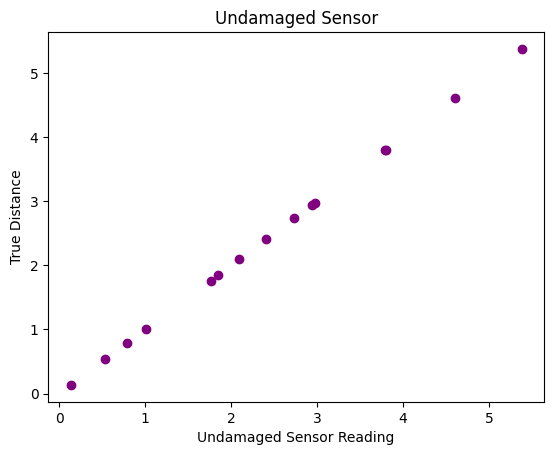

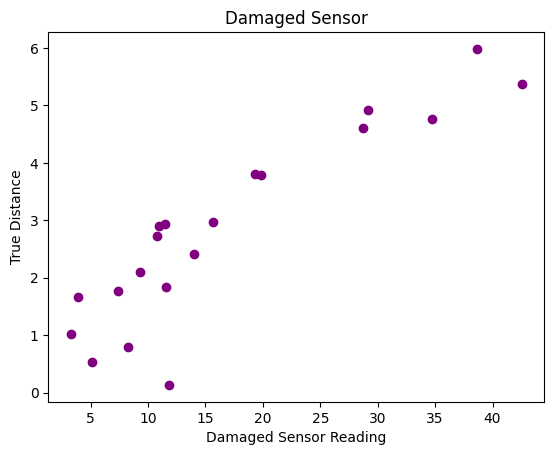

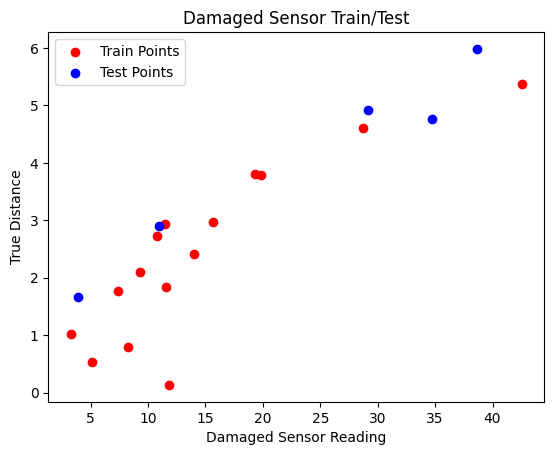

In [3]:
def distances_dataset(num=20, noise_scale = 3.0):
    with torch.no_grad():
        satellite_locations = 6.0*torch.rand(size = (num, ))
        sensor_noise = torch.normal(0.0,noise_scale,size=(num, ))
        transformed_locations = torch.square(satellite_locations) + sensor_noise + 5.0
        return transformed_locations[:,None], satellite_locations[:,None]

def reggie_explodes(predictor, normalizer):
    landing_x, true_distances = distances_dataset(REGGIE_EXPLODES_SAMPLES)
    landing_x_normed = normalizer.forward(landing_x)
    with torch.no_grad():
        predicted_distances = predictor.forward(landing_x_normed)
        distance_off_by = torch.mean(torch.square(true_distances - predicted_distances))
    if distance_off_by > REGGIE_EXPLODES_THRESHOLD:
        print("Reggie Exploded on Impact")
    else:
        print(f"Landing Success! Landing distance from center:{distance_off_by}")

train_x, train_y = distances_dataset(15)
test_x, test_y = distances_dataset(5)

plt.title("Undamaged Sensor")
plt.scatter(train_y, train_y, color="purple")
plt.xlabel("Undamaged Sensor Reading")
plt.ylabel("True Distance")
plt.show()
plt.cla()

plt.title("Damaged Sensor")
plt.scatter(train_x, train_y, color="purple")
plt.scatter(test_x, test_y, color="purple")
plt.xlabel("Damaged Sensor Reading")
plt.ylabel("True Distance")
plt.show()
plt.cla()

plt.title("Damaged Sensor Train/Test")
plt.scatter(train_x, train_y, color="red", label="Train Points")
plt.scatter(test_x, test_y, color="blue", label="Test Points")
plt.xlabel("Damaged Sensor Reading")
plt.ylabel("True Distance")
plt.legend()
plt.show()

Sets up the training functions for later use

In [4]:
def mse_loss(x,y):
    return torch.mean((x - y)**2)

def train_network(train_x, train_y, test_x, test_y, neural_net, lr = 0.0001, 
                  epochs= 100, batch_size = 20, loss_func= mse_loss, l1=0.1, l2=0.0):
    train_dataset = TensorDataset(train_x, train_y)
    batched_train_data = DataLoader(train_dataset,batch_size= batch_size,shuffle=True)
    optimizer = torch.optim.Adam(neural_net.parameters(), lr=lr)
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        neural_net.train()
        batch_losses = []
        for batch_x, batch_y in batched_train_data:
            optimizer.zero_grad()
            y_hat = neural_net.forward(batch_x)
            loss = loss_func(batch_y, y_hat)
            if not (l1 == 0.0):
                loss += l1*sum(torch.linalg.norm(p, 1) for p in neural_net.parameters())
            if not (l2 == 0.0):
                loss += l2*sum(p.pow(2).sum() for p in neural_net.parameters())
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.clone().detach().numpy())
        train_loss = np.mean(batch_losses)
        train_losses.append(train_loss)
        with torch.no_grad():
            neural_net.eval()
            y_hat_test = neural_net.forward(test_x)
            test_loss = loss_func(test_y, y_hat_test).clone().detach().numpy()
            test_losses.append(test_loss)
        print(f"epoch {epoch} : train: {train_loss} ___ test: {test_loss}")
    return train_losses, test_losses

class Normalize():
    def __init__(self, x_init):
        with torch.no_grad():
            self.mu = torch.mean(x_init)
            self.std = torch.std(x_init)
    def forward(self,x):
        return (x - self.mu)/self.std

def train_and_plot_neural_net(train_x, train_y, test_x, test_y, neural_net, epochs=1000, batch_size = 8, lr = 1e-4, l1 = 0.0, l2 = 0.0):
    standardize = Normalize(train_x)
    train_x_norm = standardize.forward(train_x)
    test_x_norm = standardize.forward(test_x)

    xs_plot = torch.linspace(0.0, PLOTTING_MAX_VAUE, 100)[:,None]
    xs_plot_standardized = standardize.forward(xs_plot)

    #gets the initial predictions of the randomly init neural network 
    with torch.no_grad():
        initial_y_hat = neural_net.forward(xs_plot_standardized)

    train_losses, test_losses = train_network(train_x_norm,train_y, test_x_norm, test_y, neural_net, epochs = epochs, batch_size=batch_size, lr = lr, l1 = l1, l2=l2)

    #plots the trained neural network
    with torch.no_grad():
        ys_plot_hat = neural_net.forward(xs_plot_standardized)

    #plots the initial neural network
    plt.title("Randomly Initialized Prediction")
    plt.plot(xs_plot, initial_y_hat,color="black")
    plt.xlabel("Damaged Sensor Reading")
    plt.ylabel("Predicted True Distance")
    plt.show()
    plt.cla()

    #plots the trained neural network
    final_train_mse = train_losses[-1]
    final_test_mse = test_losses[-1]
    plt.title(f"Sensor Calibration: Train MSE:{'%.3f' %final_train_mse} Test MSE:{'%.3f' %final_test_mse}")
    plt.scatter(train_x, train_y, color= "red",label="Train Points")
    plt.scatter(test_x, test_y, label="Test Points")
    plt.plot(xs_plot, ys_plot_hat,label="NN Predicted Distance", color="black")
    plt.xlabel("Damaged Sensor Reading")
    plt.ylabel("True Distance")
    plt.legend()
    plt.show()
    plt.cla()

    #plots the losses over training
    plt.title("Sensor Calibration Train/Test Loss Over Epochs")
    plt.plot(train_losses,label="Train Loss", color="red")
    plt.plot(test_losses, label="Test Loss", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()
    plt.cla()
    return neural_net, standardize


Trains the initial neural network

epoch 0 : train: 8.933350563049316 ___ test: 19.952775955200195
epoch 1 : train: 8.612773895263672 ___ test: 19.939008712768555
epoch 2 : train: 8.832450866699219 ___ test: 19.925477981567383
epoch 3 : train: 8.968183517456055 ___ test: 19.912010192871094
epoch 4 : train: 8.85090446472168 ___ test: 19.898405075073242
epoch 5 : train: 9.090625762939453 ___ test: 19.885066986083984
epoch 6 : train: 8.95102310180664 ___ test: 19.871503829956055
epoch 7 : train: 8.566092491149902 ___ test: 19.85763931274414
epoch 8 : train: 8.764888763427734 ___ test: 19.843996047973633
epoch 9 : train: 8.565775871276855 ___ test: 19.83034896850586
epoch 10 : train: 8.738774299621582 ___ test: 19.816911697387695
epoch 11 : train: 8.670001029968262 ___ test: 19.80343246459961
epoch 12 : train: 8.932849884033203 ___ test: 19.790176391601562
epoch 13 : train: 8.937145233154297 ___ test: 19.77682113647461
epoch 14 : train: 8.596983909606934 ___ test: 19.763240814208984
epoch 15 : train: 8.898102760314941 ___ t

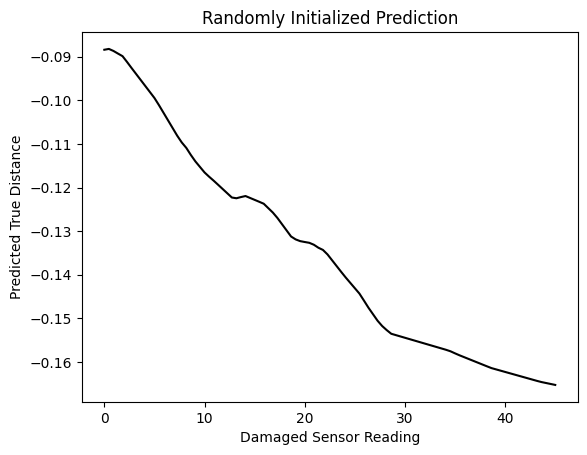

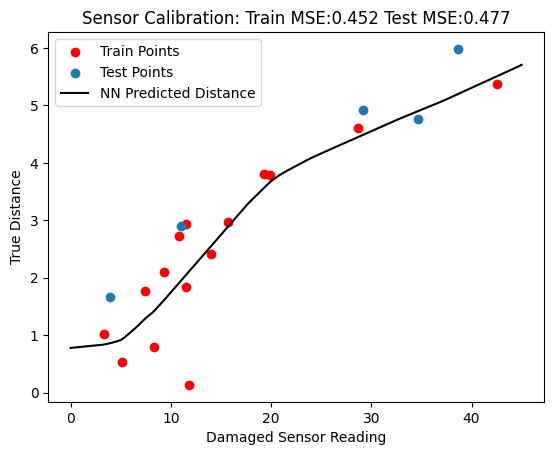

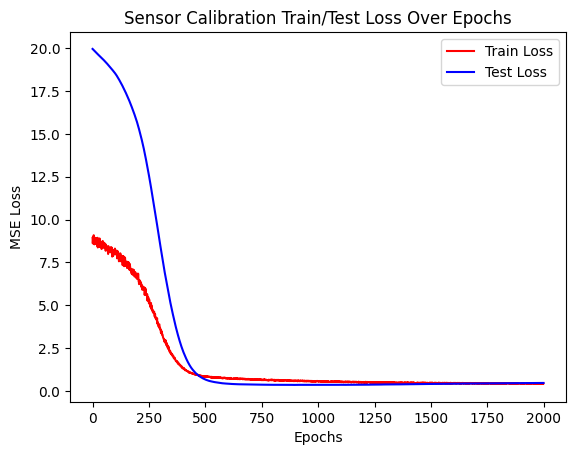

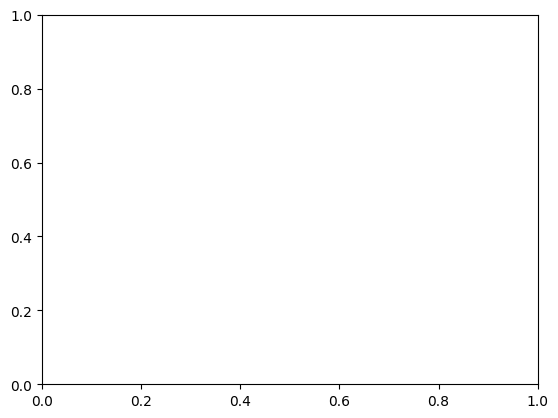

In [5]:
class Relu3LayerFeedForward(nn.Module):
    def __init__(self,in_dims=1, out_dims=1,
                layer_size=10):
        super().__init__()
        self.layer_1_linear = nn.Linear(in_dims,layer_size)
        self.layer_1 = nn.ReLU()
        self.layer_2_linear = nn.Linear(layer_size, layer_size)
        self.layer_2 = nn.ReLU()
        self.layer_3_linear = nn.Linear(layer_size,layer_size)
        self.layer_3 = nn.ReLU()
        self.out = nn.Linear(layer_size, out_dims)

    def forward(self,x):
        x = self.layer_1_linear(x)
        x = self.layer_1(x)
        x = self.layer_2_linear(x)
        x = self.layer_2(x)
        x = self.layer_3_linear(x)
        x = self.layer_3(x)
        x = self.out(x)
        return x
    
epochs = 2000
basic_neural_net = Relu3LayerFeedForward(layer_size=20)
_, standardize = train_and_plot_neural_net(train_x, train_y, test_x, test_y, basic_neural_net, epochs = epochs)



See if basic neural net explodes Rob

In [6]:
reggie_explodes(basic_neural_net, standardize)

Landing Success! Landing distance from center:0.3337845504283905


Shows the issue of overfitting

epoch 0 : train: 7.449518203735352 ___ test: 17.521059036254883
epoch 1 : train: 7.434421062469482 ___ test: 17.486021041870117
epoch 2 : train: 7.419410228729248 ___ test: 17.45107078552246
epoch 3 : train: 7.404500961303711 ___ test: 17.41621971130371
epoch 4 : train: 7.389638423919678 ___ test: 17.38173484802246
epoch 5 : train: 7.374787330627441 ___ test: 17.347230911254883
epoch 6 : train: 7.3600172996521 ___ test: 17.31275749206543
epoch 7 : train: 7.345301151275635 ___ test: 17.2783203125
epoch 8 : train: 7.330568790435791 ___ test: 17.24359130859375
epoch 9 : train: 7.315639972686768 ___ test: 17.208425521850586
epoch 10 : train: 7.300744533538818 ___ test: 17.172901153564453
epoch 11 : train: 7.285876274108887 ___ test: 17.137060165405273
epoch 12 : train: 7.271014213562012 ___ test: 17.101125717163086
epoch 13 : train: 7.256162643432617 ___ test: 17.064828872680664
epoch 14 : train: 7.241191387176514 ___ test: 17.028396606445312
epoch 15 : train: 7.2261481285095215 ___ test: 

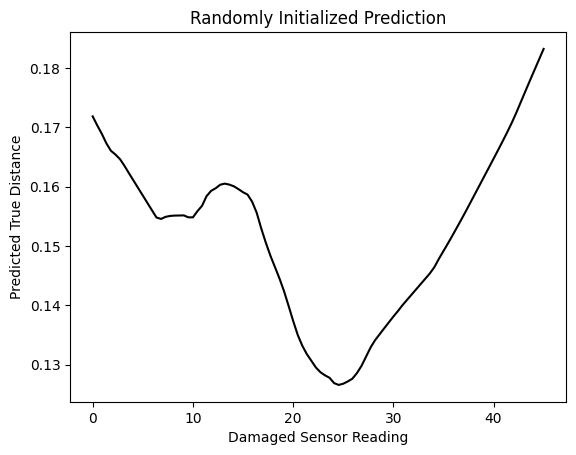

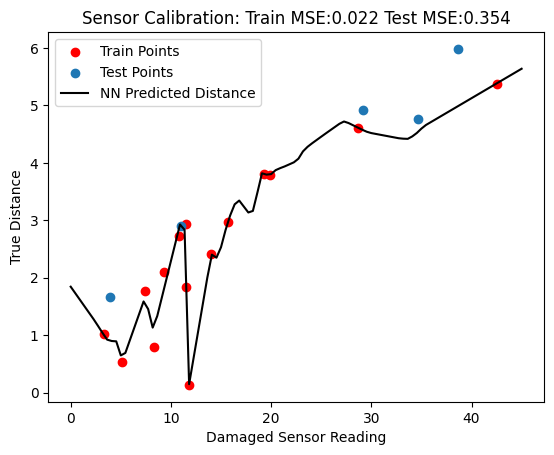

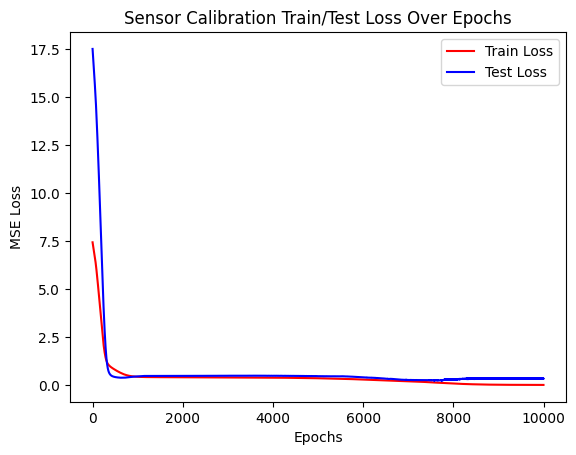

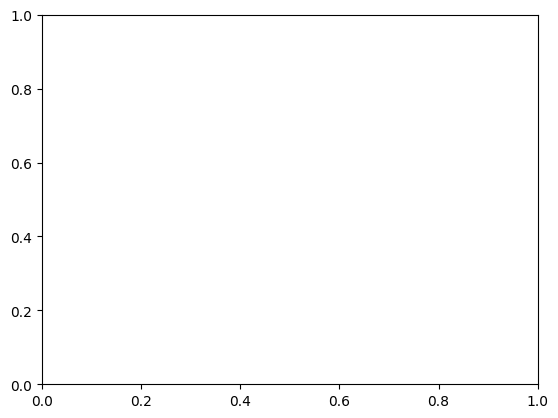

In [7]:
epochs = 10000
overfit_neural_net = Relu3LayerFeedForward(layer_size=50)
_, standardize = train_and_plot_neural_net(train_x, train_y, test_x, test_y, overfit_neural_net, epochs = epochs,lr=1e-4,batch_size = 20)

In [8]:
reggie_explodes(overfit_neural_net, standardize)

Reggie Exploded on Impact


Now using the same experiment setup where we overfit, we add regularization to the network. Regularization changes the flexibility of a neural network by adding terms to the loss function that penalize the weights of the neural network. It leads to simpler functions that are less "wiggley" and don't overfit as poorly assuming the underlying function you are trying to estimate is smooth.

epoch 0 : train: 9.000335693359375 ___ test: 19.084396362304688
epoch 1 : train: 8.982751846313477 ___ test: 19.03890037536621
epoch 2 : train: 8.965173721313477 ___ test: 18.993764877319336
epoch 3 : train: 8.947683334350586 ___ test: 18.948862075805664
epoch 4 : train: 8.930276870727539 ___ test: 18.903881072998047
epoch 5 : train: 8.912936210632324 ___ test: 18.858694076538086
epoch 6 : train: 8.895675659179688 ___ test: 18.813678741455078
epoch 7 : train: 8.878358840942383 ___ test: 18.768798828125
epoch 8 : train: 8.861002922058105 ___ test: 18.72391128540039
epoch 9 : train: 8.843680381774902 ___ test: 18.678531646728516
epoch 10 : train: 8.82639217376709 ___ test: 18.633981704711914
epoch 11 : train: 8.809127807617188 ___ test: 18.589462280273438
epoch 12 : train: 8.791894912719727 ___ test: 18.544963836669922
epoch 13 : train: 8.774681091308594 ___ test: 18.500484466552734
epoch 14 : train: 8.757377624511719 ___ test: 18.456012725830078
epoch 15 : train: 8.740110397338867 ___ t

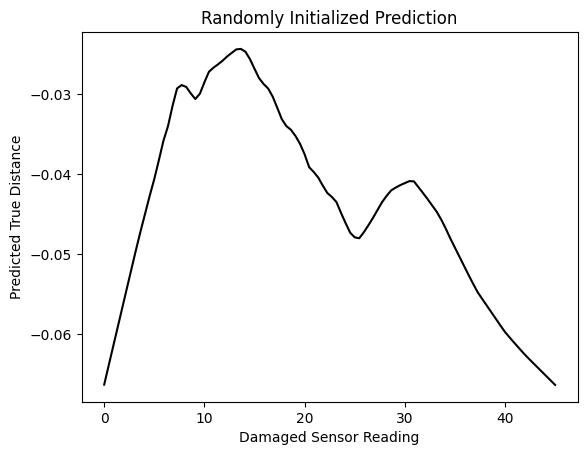

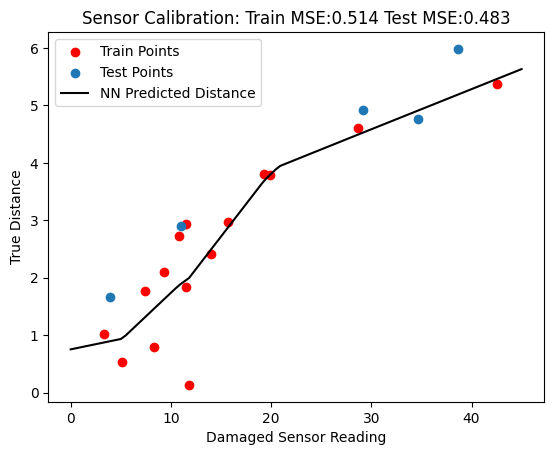

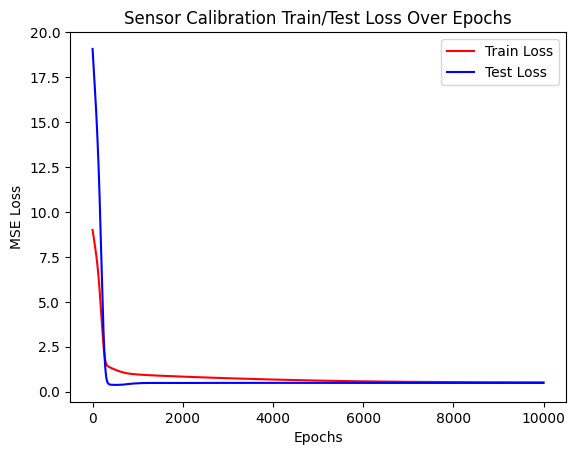

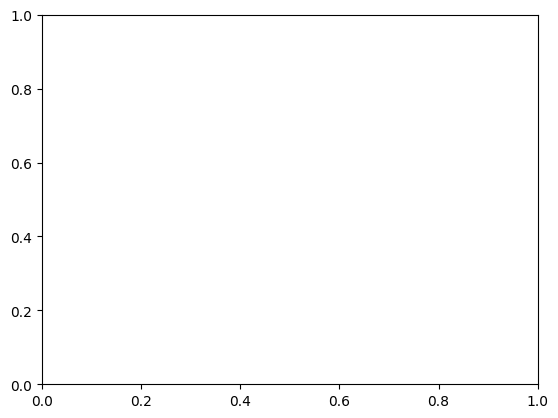

In [9]:
epochs = 10000
l2_regularized_neural_net = Relu3LayerFeedForward(layer_size=50)
_, standardize = train_and_plot_neural_net(train_x, train_y, test_x, test_y, l2_regularized_neural_net, epochs = epochs,lr=1e-4,batch_size = 20,l2 = 0.01)

Time to see if Rob explodes using the regularized neural net to calibrate!

In [10]:
reggie_explodes(l2_regularized_neural_net,standardize)

Landing Success! Landing distance from center:0.4547337293624878
